# Monge, Bregman and Occam
Augustin Cramer, Claire Dechaux et Emanie Luu


## The Monge Problem

The Monge Problem delves into identifying, among all possible mappings $T: \mathbb{R}^d \to \mathbb{R}^d$ that push-forward a measure $\mu \in \mathcal{P}\left(\mathbb{R^d}\right)$
onto $\nu \in \mathcal{P}\left(\mathbb{R^d}\right)$, and using a cost function $c(x, y)$ as a measure of the length of the displacement, the most efficient maps. These optimal mappings are characterized as follows:  
$$T^\star := \underset{T\#\mu=\nu }{\arg \inf}\int_{\mathbb{R^d}}^{} c(x, T(x))d\mu$$.

## Sparsity inducing costs
Considering a translation-invariant cost function $c(x, y) := h\left(x-T(x)\right)$, we will shed the light on particular cost functions that can induce sparse transportations, ie $\left\|\Delta(x)  \right\|_0 \ll  d$ where $\Delta(x) := x-T(x)\in \mathbb{R}^d$ is the displacement vector.

Elastic costs are functions of the form $c(x, y) = h_\tau(x - y)$ with $h_\tau(z) = \frac{1}{2} \left\|z\right\|_2^2 + \tau(z)$. $\tau$ is a regularizer that, generally speaking, can be any regularizer as long as its proximal operator is known in closed form. Among these regularizers, we will study the l1 norm and show its sparsity inducing proprieties using OTT-JAX.

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [2]:
import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt

import ott
from tqdm import tqdm
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.geometry.costs import ElasticSTVS, ElasticL1, ElasticL2, ElasticSqKOverlap, SqEuclidean
from ott.tools.gaussian_mixture import (
    gaussian_mixture,
)
from ott.tools import sinkhorn_divergence

## 1. Synthetic experiment

We start first by testing the estimator on a synthetic dataset.

In [3]:
rng = jax.random.PRNGKey(0)

In [4]:
def make_distribution_generators(d):
    # Source distribution, a simple gaussian points cloud
    mean_generator0 = jnp.zeros((1,d))
    cov_generator0 = jnp.array(
        [
            jnp.diag(jnp.full((d,), 0.2)),
        ]
    )
    weights_generator0 = jnp.ones((1,))

    gm_generator0 = (
        gaussian_mixture.GaussianMixture.from_mean_cov_component_weights(
            mean=mean_generator0,
            cov=cov_generator0,
            component_weights=weights_generator0,
        )
    )

    # Target distribution, a gaussian mixture that will envelope one side of the
    # source distribution
    mean_generator1 = jnp.diag(jnp.full((d,), 2.0))
    cov_generator1 =  jnp.fill_diagonal(jnp.array(
        [
        jnp.diag(jnp.full((d,), 0.2)) for i in range(d)
        ]
    ), 0.05, inplace=False)
    weights_generator1 = jnp.ones((d,))


    gm_generator1 = (
        gaussian_mixture.GaussianMixture.from_mean_cov_component_weights(
            mean=mean_generator1,
            cov=cov_generator1,
            component_weights=weights_generator1,
        )
    )
    return gm_generator0, gm_generator1

First, let's visualize what it looks like in two dimensions.

In [5]:
d = 2
gm_generator0, gm_generator1 = make_distribution_generators(d)

In [6]:
N = 1000
rng, rng1, rng2 = jax.random.split(rng, num=3)
x = gm_generator0.sample(rng=rng1, size=N)
y = gm_generator1.sample(rng=rng2, size=N)

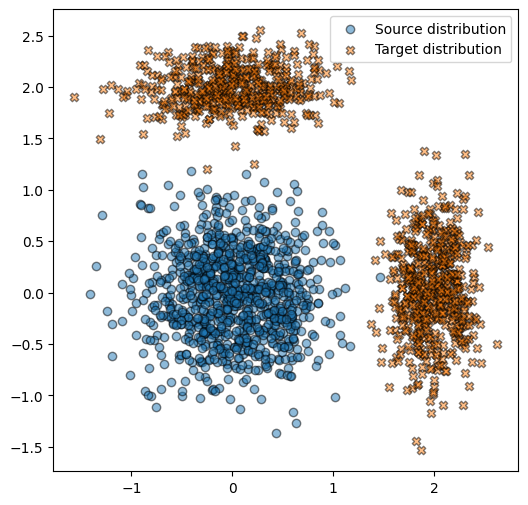

In [7]:
plt.figure(figsize=(6, 6))
plt.scatter(x[:, 0], x[:, 1], edgecolors="k", marker="o", alpha=0.5, label="Source distribution")
plt.scatter(y[:, 0], y[:, 1], edgecolors="k", marker="X", alpha=0.5, label="Target distribution")
plt.legend()
plt.show()

Now, let's compare sparsity and sinkhorn divergence when using the regular l2 norm and the elastic types norms.

In [8]:
solver = jax.jit(sinkhorn.Sinkhorn())
def entropic_map(x, y, cost_fn: costs.TICost) -> jnp.ndarray:
    geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn)
    output = solver(linear_problem.LinearProblem(geom))
    dual_potentials = output.to_dual_potentials()
    return dual_potentials.transport

In [9]:
def compute_sinkhorn_divergence(map, new):
  return sinkhorn_divergence.sinkhorn_divergence(pointcloud.PointCloud, map(new), y, cost_fn=SqEuclidean()).divergence

In [10]:
supp_d = [8, 20, 100] # select the wanted dimensions
#supp_d = [80]

costs_fns = {
    "elastic_l1": ElasticL1,
    "tau_stvs": ElasticSTVS,
    "l2": lambda x: SqEuclidean(),
    #"ovk_5": lambda x: ElasticSqKOverlap(5, scaling_reg=x),
    #"ovk_7": lambda x: ElasticSqKOverlap(7, scaling_reg=x)
    }

res = {d:{"sparsity": {
    "elastic_l1": [],
    "tau_stvs": [],
    "l2": [],
    #"ovk_5": [],
    #"ovk_7": []
},
    "sink_div": {
    "elastic_l1": [],
    "tau_stvs": [],
    "l2": [],
    #"ovk_5": [],
    #"ovk_7": []
}} for d in supp_d}

In [11]:
n_points = 30
supp_reg = np.logspace(-2, 1, n_points)

for d in supp_d:
    gmm_generator0, gmm_generator1 = make_distribution_generators(d)
    y = gmm_generator0.sample(rng=rng1, size=N)
    x = gmm_generator1.sample(rng=rng2, size=N)
    new = gmm_generator0.sample(rng=rng, size=N)
    for cost_name, cost_fn in tqdm(costs_fns.items()):
        for reg in supp_reg:
            map = entropic_map(x, y, cost_fn(reg))
            res[d]["sparsity"][cost_name].append(((new - map(new)) < 1e-6).mean())
            res[d]["sink_div"][cost_name].append(compute_sinkhorn_divergence(map, new))

100%|██████████| 3/3 [15:56<00:00, 318.97s/it]


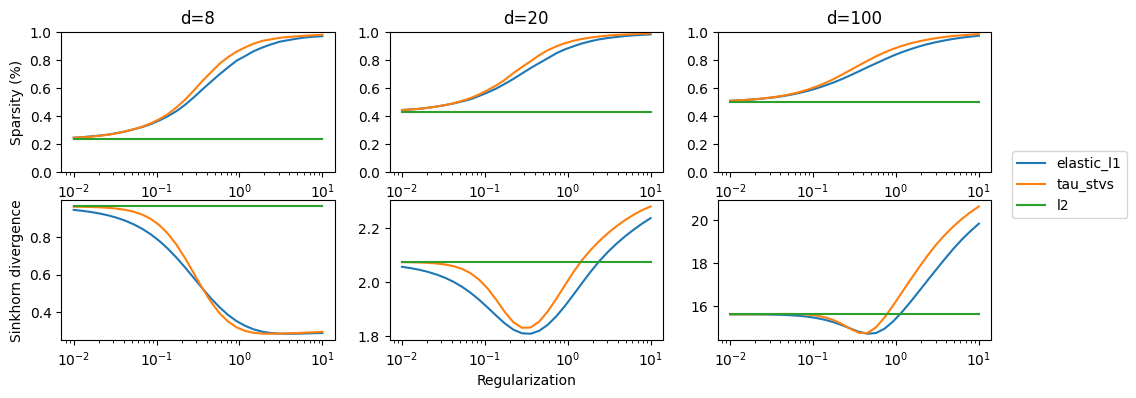

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(12, 4))
for i, d in enumerate(supp_d):
    for cost_name, sparsity in res[d]["sparsity"].items():
        ax[0,i].plot(supp_reg, sparsity, label=cost_name)
    ax[0,i].set_xscale("log")
    ax[0,i].set_title(f"d={d}")
    ax[0,i].set_ylim(0, 1)
    for cost_name, sink_div in res[d]["sink_div"].items():
        ax[1,i].plot(supp_reg, sink_div,  label=cost_name)
    ax[1,i].set_xscale("log")
ax[0,2].legend(bbox_to_anchor=(1.05, 0.2), loc='upper left')
ax[0, 0].set_ylabel("Sparsity (%)")
ax[1, 0].set_ylabel("Sinkhorn divergence")
ax[1, 1].set_xlabel("Regularization")
plt.show()

## 2. Application on a real dataset

We have chosen to employ the OCAM estimator on genomic data. This data was extracted from the Microarray Expression files for dataset GSE6008 sourced from the GEO database, focusing specifically on patients with Ovarian Tumors (data source: https://sbcb.inf.ufrgs.br/cumida). Our objective is to compare the distributions of genetic data between patients diagnosed with tumors and those deemed healthy.

In [ ]:
!pip install scanpy

In [14]:
from imblearn.over_sampling import SMOTE
import scanpy as sc
import pandas as pd

In [15]:
!gdown 1lFpZKgVsp9tkNKtCzGB3tzdsV1xBIJCH
!gdown 1bgsTib_XmssK25oBb3LOSbI1dEIARv6j
!gdown 1AGPmD1jNlVBSyf-BysE-lXX9LUUQhI_1

zsh:1: command not found: gdown


zsh:1: command not found: gdown


/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


zsh:1: command not found: gdown


In [ ]:
# Load data
source_data = pd.read_csv('/content/train.csv', index_col=0)
source_test_data = pd.read_csv('/content/test.csv', index_col=0)
target_data = pd.read_csv('/content/ovary_normal.csv', index_col=0)
target_data.reset_index(inplace=True)

In [ ]:
source_data.head()

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Hs28SrRNA-5_at,AFFX-r2-Hs28SrRNA-M_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
88,GSM139466.CEL.gz,Ovarian_Tumor_Serous,10.657338,7.334390,6.008316,11.110976,4.369533,8.405554,5.394035,5.132351,...,4.420118,5.289211,12.830594,12.903713,4.690083,4.282668,4.141177,3.923703,4.111312,4.094231
23,GSM139400.CEL.gz,Ovarian_Tumor_Endometrioid,11.491874,6.683240,5.902034,10.236538,4.421190,7.685912,5.674513,5.128294,...,4.600560,5.540428,13.295688,13.478680,4.813273,4.386874,4.218702,3.986668,4.155982,4.076248
48,GSM139426.CEL.gz,Ovarian_Tumor_Mucinous,10.314452,6.495305,6.067844,8.932200,4.313781,7.720813,5.557916,5.193771,...,4.753995,5.827996,13.434393,13.707801,4.901715,4.456844,4.249358,4.043522,4.229169,4.102726
14,GSM139391.CEL.gz,Ovarian_Tumor_Endometrioid,10.513461,6.422066,6.011060,9.872251,4.256327,7.600642,5.542977,4.997941,...,4.625638,5.529046,13.135787,13.222189,4.791806,4.283359,4.063190,3.921959,4.149170,4.063612
63,GSM139441.CEL.gz,Ovarian_Tumor_Serous,10.974670,7.051280,5.961062,10.835584,4.279674,8.352425,5.664856,5.197727,...,4.754682,5.958735,12.359415,11.651661,5.044779,4.474342,4.202246,4.020624,4.276949,4.062319


In [ ]:
source_data["type"].value_counts()

type
Ovarian_Tumor_Serous          33
Ovarian_Tumor_Endometrioid    29
Ovarian_Tumor_Mucinous        10
Ovarian_Tumor_ClearCel         6
Name: count, dtype: int64

In [ ]:
target_data.head()

,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,AFFX-r2-Hs28SrRNA-5_at,AFFX-r2-Hs28SrRNA-M_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,Ovary_Normal,8.2219,6.5762,6.2032,8.4583,4.2346,7.9419,5.5528,5.2171,5.4656,...,10.8515,10.2469,6.0071,6.1099,5.2877,7.5819,4.5681,5.8733,12.2896,12.0984
1,Ovary_Normal,8.7909,6.5613,5.8782,8.1932,4.2951,7.9068,5.5619,5.1609,6.1075,...,11.0888,10.6491,6.0357,6.0607,5.1800,7.1662,4.5722,5.7452,12.3919,12.0342
2,Ovary_Normal,8.5098,6.5455,5.8502,8.9439,4.3357,8.3846,5.5148,5.1128,5.0013,...,11.2063,10.8194,6.2030,6.3726,5.3514,8.0629,4.5978,6.6470,12.3631,11.8649
3,Ovary_Normal,8.3382,6.7284,5.8261,8.3893,4.1542,8.0292,5.2084,5.0383,5.0082,...,11.0463,10.6203,5.9621,6.0300,5.3857,7.0177,4.4093,6.1352,12.2740,12.0415


### 2.1 Using Scanpy to reduce dimensionality

In [ ]:
# Concatenate source and target data
full_data = pd.concat([source_data.drop("samples", axis=1), target_data])

# Extract tumor types
tumor_types = full_data["type"].ravel()

# Extract features
features = full_data.drop(['type'], axis=1)

# Fill missing values with 0
features.fillna(value=0, inplace=True)

# Convert DataFrame to AnnData object
adata = sc.AnnData(features)

# Perform feature selection (e.g., highly variable genes selection)
sc.pp.highly_variable_genes(adata, n_top_genes=10000)

# Retrieve the indices of the top features
top_feature_indices = adata.var_names[adata.var['highly_variable']]

# Subset the data to keep only the top features
features_top = features.loc[:, top_feature_indices]
X_test = source_test_data.loc[:, top_feature_indices]

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### 2.2 Data Augmentation with Smote

In [ ]:
# Define sampling strategy for SMOTE
sampling_strategy = {
    'Ovarian_Tumor_Mucinous': 50,
    'Ovarian_Tumor_ClearCel': 50,
    'Ovarian_Tumor_Endometrioid': 50,
    'Ovarian_Tumor_Serous' : 50,
    'Ovary_Normal' : 200,
}

# Instantiate SMOTE with sampling strategy and adjust k_neighbors
smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=2)

# Apply SMOTE to resample the data
X_train_resampled, y_train_resampled = smote.fit_resample(features_top, tumor_types)

# Create complete data
complete_data = X_train_resampled.copy()
complete_data["type"] = y_train_resampled

# Separate source and target data
source_data = complete_data[complete_data["type"] == "Ovary_Normal"].drop("type", axis=1)
target_data = complete_data[complete_data["type"] == "Ovarian_Tumor_Mucinous"].drop("type", axis=1)

# Normalize source and target data
# X_source = source_data.values / source_data.values.sum(axis=1)[:, np.newaxis]
# X_target = target_data.values / target_data.values.sum(axis=1)[:, np.newaxis]
# x_test = X_test.values / X_test.values.sum(axis=1)[:, np.newaxis]

# Assign to variables X and y
x = source_data.values
y = target_data.values
x_test = X_test.values

/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (50) in class Ovarian_Tumor_Mucinous will be larger than the number of samples in the majority class (class #Ovarian_Tumor_Serous -> 33)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (50) in class Ovarian_Tumor_ClearCel will be larger than the number of samples in the majority class (class #Ovarian_Tumor_Serous -> 33)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (50) in class Ovarian_Tumor_Endometrioid will be larger than the number of samples in the majority class (class #Ovarian_Tumor_Serous -> 33)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (50) in cl

### 2.3 Estimator OCAM

In [ ]:
x.shape, y.shape, x_test.shape

((200, 10000), (50, 10000), (20, 10000))

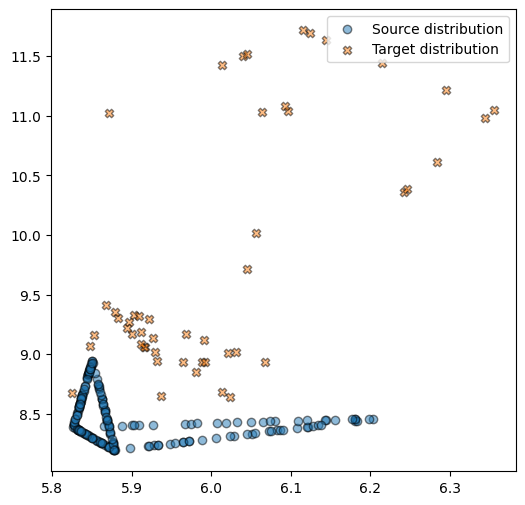

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(x[:, 0], x[:, 1], edgecolors="k", marker="o", alpha=0.5, label="Source distribution")
plt.scatter(y[:, 0], y[:, 1], edgecolors="k", marker="X", alpha=0.5, label="Target distribution")
plt.legend()
plt.show()

In [ ]:
d = 10000
s = 100
n_points = 50

solver = jax.jit(sinkhorn.Sinkhorn())

costs_fns = {
    "l2": lambda x: SqEuclidean(),
    "elastic_l1": ElasticL1,
    "tau_stvs": ElasticSTVS
    }


res = {
    "elastic_l1": [],
    "l2": [],
    "tau_stvs": []
}

for cost_name, cost_fn in tqdm(costs_fns.items()):
    for reg in np.logspace(-2, 2, n_points):
        cost = pointcloud.PointCloud(x, y, cost_fn=cost_fn(reg))
        prob = linear_problem.LinearProblem(cost)
        out = solver(prob)
        dual_potentials = out.to_dual_potentials()

        map = entropic_map(x, y, cost_fn(reg))
        sk_d = compute_sinkhorn_divergence(map, x_test)

        res[cost_name].append(sk_d)

100%|██████████| 3/3 [04:54<00:00, 98.08s/it]


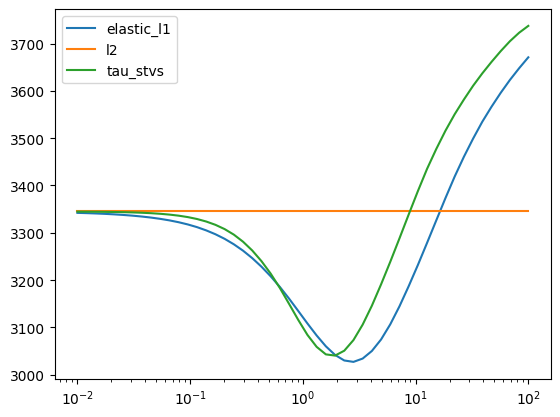

In [ ]:
for cost_name, cost_res in res.items():
    plt.plot(np.logspace(-2, 2, n_points), cost_res, label=cost_name)
plt.xscale("log")
plt.legend()

The plot illustrates that we can select a particular value of the regularizer to minimize the Sinkhorn Divergence. Additional tests can be conducted by adjusting the number of retained features and the quantity of samples added. Utilizing more authentic data rather than relying solely on artificial data augmentation could potentially enhance the outcomes.